In [1]:
!pip install lightly==1.4.7

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.6/647.6 kB 13.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.8 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144575 sha256=fadbd0b2f8406364f5e13a159addb8f6567503ffd61668f688d175659b195995
  Stored in directory: /root/.cache/pip/wheels/8b/8d/53/2af8772d9aec614e3fc65e53d4a993ad73c61daa8bbd85a873
Successfully built antlr4-python3-runtime


## Imports





In [2]:
# basic imports
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

##  BDD100k Dataset

- A Diverse Driving Dataset for heterogenous Multi Task learning
- It has labeled annotations for 1000 hours videos, 10 tasks like Object Detection, Semantic Segmentation, Panoptic Segmentation, Instance Segmentation, Drivable Area estimation etc

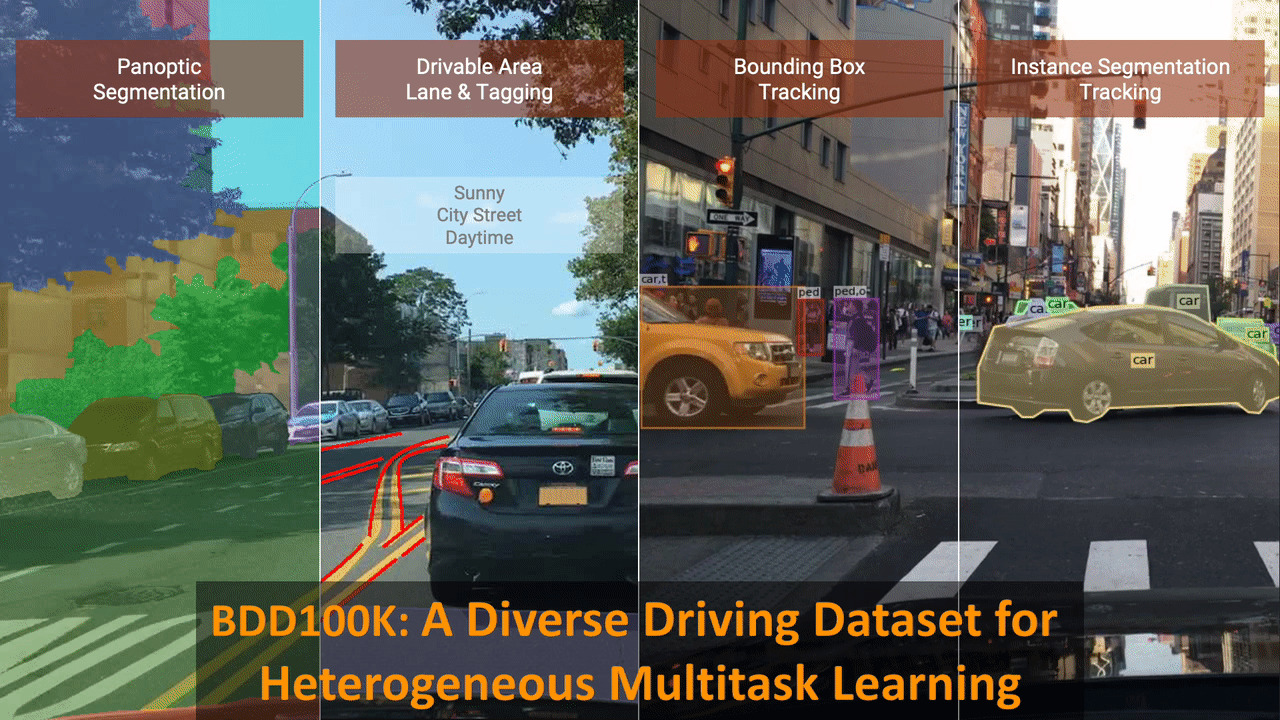

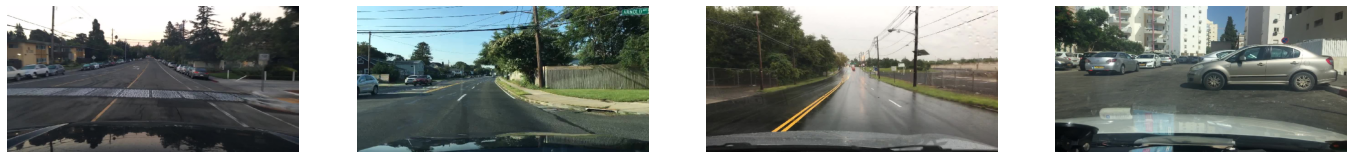

In [3]:
dataDir = '/kaggle/input/ssl-bdd100k-images/images_320_640'
filePaths = sorted([os.path.join(dataDir, x) for x in os.listdir(dataDir)])

from PIL import Image

fig, axes = plt.subplots(1,4, figsize= (24, 12))
for ax in axes.flatten():
    path = filePaths[np.random.randint(0, len(filePaths))]
    image = Image.open(path).convert('RGB')
    ax.imshow(image)
    ax.axis('off')

plt.show()

One thing to note is images are **not object-centered**, from different viewpoints, unlike standard datasets like ImageNet. Now that we've explored our data, we'll get more 'PyTorch friendly' and create a Dataset object, as well as a PyTorch Dataloader.

In [4]:
import cv2
import torch
from torch.utils.data import Dataset, DataLoader

class CLRDataset(Dataset):
    def __init__(self, rootDir, tf):
        self.rootDir = rootDir
        self.filePaths =  sorted([os.path.join(self.rootDir, x) for x in os.listdir(self.rootDir)])
        self.tf = tf
        
    def __len__(self):
        return len(self.filePaths)
    
    def __getitem__(self, index):
        # read source image and convert to RGB
        path = self.filePaths[index]        
        with open(path, "rb") as f:
            image = Image.open(f)
            image.convert("RGB")
    
        if self.tf is not None:
            image = self.tf(image)
        return image, path

- Now, we need to define the transformations for our images. In contrastive learning, we typically create multiple views of same scene and ask the model to differentiate b/w the same scene and different one as positive and negative samples. **Data augmentations play a key role**
- Specifically, we'll be using the transformations used in [SimCLR1](https://arxiv.org/abs/2002.05709) and [SimCLR2](https://arxiv.org/abs/2006.10029)
- Augmentaions used in SimCLR method are as follows:
    - Random resized crop
    - Random horizontal flip
    - Color jitter
    - Random gray scale
    - Gaussian blur
    - ImageNet normalization
    
**lightly** has already implemented a pytorch-friendly class of the above transformations. We can find similar implementaions for popular models in [lighlty transforms](https://github.com/lightly-ai/lightly/tree/master/lightly/transforms)

In [5]:
import torchvision
from lightly import transforms as lightly_transforms

input_size = 128
train_transform = lightly_transforms.SimCLRTransform(
                input_size=input_size, min_scale=0.25, rr_prob=0.5, rr_degrees=(-10,10))
train_dataset = CLRDataset(rootDir=dataDir, tf=train_transform)

We'll visualize augmentations applied on some of the samples

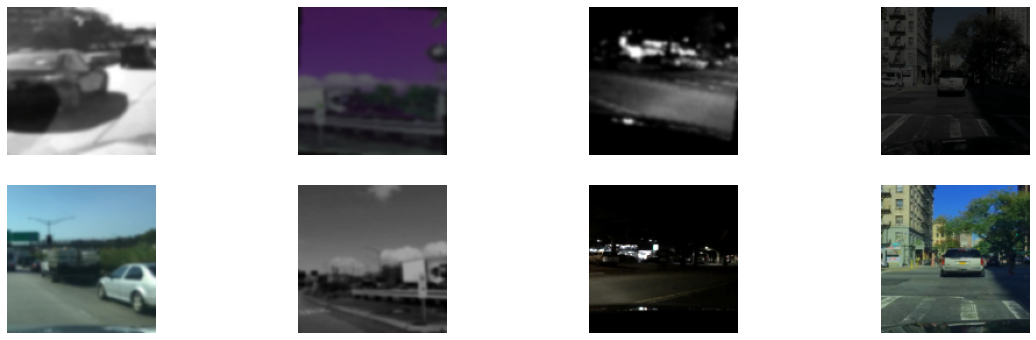

In [6]:
# when using torch datasets we defined earlier, the output image is normalized. 
# So we're defining an inverse transformation to transform to normal RGB format
inverse_transform = torchvision.transforms.Compose([
        torchvision.transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
    ])

def invert_normalize(inputImage):
    return inverse_transform(inputImage).permute(1, 2, 0).cpu().detach().numpy()

num_samples = 4
fig, axes = plt.subplots(2, num_samples, figsize= (20, 6))
for i in range(num_samples):
    (img_view1, img_view2), _ = train_dataset[np.random.randint(0, len(train_dataset))]
    
    # inverse normalization and plot view1
    img_view1 = invert_normalize(img_view1)
    axes[0, i].imshow(img_view1)
    axes[0, i].axis('off')
    
    # inverse normalization and plot view2
    img_view2 = invert_normalize(img_view2)
    axes[1, i].imshow(img_view2)
    axes[1, i].axis('off')


In [7]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True, num_workers=2)

## Model
Resnet50 backbone + SimCLR Projection head

In [8]:
import torch
import torch.nn as nn
from lightly.models.modules.heads import SimCLRProjectionHead

class SimCLRModel(nn.Module):
    def __init__(self):    
        super(SimCLRModel, self).__init__()
        # create a ResNet backbone and remove the classification head
        # The dilation parameters are given, as backbone will be reused with deeplabv3+ model
        backbone = torchvision.models.resnet50(pretrained=True, replace_stride_with_dilation =[False, True, True])
        self.initial = nn.Sequential(*list(backbone.children())[:4])
        self.layer1 = backbone.layer1
        self.layer2 = backbone.layer2
        self.layer3 = backbone.layer3
        self.layer4 = backbone.layer4
        self.avgpool = backbone.avgpool

        hidden_dim = backbone.fc.in_features
        self.projection_head = SimCLRProjectionHead(hidden_dim, hidden_dim, 128)
    
    def backbone_forward(self, x):
        # Pass input through Backbone layers
        x = self.initial(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x
        
    def forward(self, x):
        x = self.backbone_forward(x)
        x = self.avgpool(x).flatten(start_dim=1)
        print(f'Avgpool output ={x.shape}')
        return self.projection_head(x)         

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimCLRModel()
model.to(device);

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [10]:
randomInput = torch.Tensor(32,3,128,128).to(device);
output = model(randomInput)
print(output.shape)  # each sample is compressed / projected to 128 dimensional feature vector

Avgpool output =torch.Size([32, 2048])
torch.Size([32, 128])


## Self-Supervised Contrastive Learning

In [11]:
from lightly.loss import NTXentLoss
# reference : https://docs.lightly.ai/self-supervised-learning/lightly.loss.html
# Contrastive Cross Entropy Loss as described in SimCLR paper
criterion = NTXentLoss()

# MODEL HYPERPARAMETERS
N_EPOCHS = 3
MAX_LR = 6e-2
MODEL_NAME = 'SimCLR_resnet50_BDD100k'

import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR, CosineAnnealingWarmRestarts

# create model, optimizer, lr_scheduler
optimizer = optim.Adam(model.parameters(), lr=MAX_LR)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0 = int(len(train_dataloader) * float(N_EPOCHS)/10), eta_min=3e-4)

In [12]:
# We monitor std.dev of the feature representations to see if model faces 
# feature-collapse, where model predicts same output for any input image
# If std.dev is 0, then outputs have collapsed to constant vector
# reference: https://arxiv.org/abs/2011.10566

from lightly.utils.debug import std_of_l2_normalized
from tqdm import tqdm

model.to(device); # move model to device

train_losses = []
std_devs = []
min_val_loss = np.Inf

for epoch in range(N_EPOCHS):    
    epoch_train_loss = 0.0
    epoch_std_devs = 0.0
    
    with tqdm(train_dataloader, unit="batch") as tepoch:
        for (image_view1, image_view2), _ in tepoch:
            tepoch.set_description(f"Epoch {epoch}")

            # pass both views to model, calculate Contrastive loss
            image_view1, image_view2 = image_view1.to(device), image_view2.to(device)
            z0 = model(image_view1)
            z1 = model(image_view2)
            loss = criterion(z0, z1)
            
            # log values
            epoch_train_loss += loss.item()
            std_dev = std_of_l2_normalized(z1).item()
            epoch_std_devs += std_dev

            # Backward pass
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()
        
            tepoch.set_postfix(loss=loss.item(), std_dev=std_dev)
    
    last_epoch_loss = epoch_train_loss / len(train_dataloader)
    train_losses.append(last_epoch_loss)
    std_devs.append(epoch_std_devs / len(train_dataloader))
    
    # save model if loss has decreased
    if last_epoch_loss <= min_val_loss:
        min_val_loss = last_epoch_loss
        torch.save(model.state_dict(), f"{MODEL_NAME}_{N_EPOCHS}ep.pt")

Epoch 0:   0%|          | 0/53 [00:01<?, ?batch/s]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 0:   2%|▏         | 1/53 [00:03<02:36,  3.02s/batch, loss=4.69, std_dev=0.089]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 0:   4%|▍         | 2/53 [00:03<01:30,  1.77s/batch, loss=4.98, std_dev=0.0495]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 0:   6%|▌         | 3/53 [00:04<01:08,  1.37s/batch, loss=5.03, std_dev=0.0458]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 0:   8%|▊         | 4/53 [00:05<00:57,  1.18s/batch, loss=4.89, std_dev=0.0465]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 0:   9%|▉         | 5/53 [00:06<00:51,  1.08s/batch, loss=5.02, std_dev=0.053] 

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 0:  11%|█▏        | 6/53 [00:07<00:47,  1.02s/batch, loss=4.87, std_dev=0.0439]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 0:  13%|█▎        | 7/53 [00:08<00:44,  1.02batch/s, loss=4.89, std_dev=0.0509]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 0:  15%|█▌        | 8/53 [00:09<00:42,  1.05batch/s, loss=4.97, std_dev=0.033] 

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 0:  17%|█▋        | 9/53 [00:10<00:41,  1.07batch/s, loss=4.92, std_dev=0.0345]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 0:  19%|█▉        | 10/53 [00:11<00:39,  1.08batch/s, loss=4.95, std_dev=0.0329]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 0:  21%|██        | 11/53 [00:11<00:38,  1.09batch/s, loss=4.9, std_dev=0.0363] 

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 0:  23%|██▎       | 12/53 [00:12<00:37,  1.10batch/s, loss=4.88, std_dev=0.0314]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 0:  25%|██▍       | 13/53 [00:13<00:36,  1.11batch/s, loss=4.89, std_dev=0.0283]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 0:  26%|██▋       | 14/53 [00:14<00:35,  1.11batch/s, loss=4.88, std_dev=0.0288]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 0:  28%|██▊       | 15/53 [00:15<00:34,  1.11batch/s, loss=4.9, std_dev=0.0313] 

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 0:  30%|███       | 16/53 [00:16<00:33,  1.11batch/s, loss=4.89, std_dev=0.0233]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 0:  32%|███▏      | 17/53 [00:17<00:32,  1.12batch/s, loss=4.86, std_dev=0.0375]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 0:  34%|███▍      | 18/53 [00:18<00:31,  1.12batch/s, loss=4.85, std_dev=0.0307]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 0:  36%|███▌      | 19/53 [00:19<00:30,  1.12batch/s, loss=4.84, std_dev=0.0383]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 0:  38%|███▊      | 20/53 [00:20<00:29,  1.12batch/s, loss=4.86, std_dev=0.0349]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 0:  40%|███▉      | 21/53 [00:20<00:28,  1.12batch/s, loss=4.81, std_dev=0.0339]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 0:  42%|████▏     | 22/53 [00:21<00:27,  1.12batch/s, loss=4.8, std_dev=0.0379] 

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 0:  43%|████▎     | 23/53 [00:22<00:26,  1.12batch/s, loss=4.85, std_dev=0.0366]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 0:  45%|████▌     | 24/53 [00:23<00:25,  1.12batch/s, loss=4.81, std_dev=0.0359]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 0:  47%|████▋     | 25/53 [00:24<00:25,  1.12batch/s, loss=4.78, std_dev=0.0291]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 0:  49%|████▉     | 26/53 [00:25<00:24,  1.12batch/s, loss=4.8, std_dev=0.0331] 

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 0:  51%|█████     | 27/53 [00:26<00:23,  1.12batch/s, loss=4.76, std_dev=0.0271]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 0:  53%|█████▎    | 28/53 [00:27<00:22,  1.12batch/s, loss=4.71, std_dev=0.0323]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 0:  55%|█████▍    | 29/53 [00:28<00:21,  1.12batch/s, loss=4.76, std_dev=0.0341]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 0:  57%|█████▋    | 30/53 [00:28<00:20,  1.12batch/s, loss=4.81, std_dev=0.0299]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 0:  58%|█████▊    | 31/53 [00:29<00:19,  1.12batch/s, loss=4.8, std_dev=0.033]  

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 0:  60%|██████    | 32/53 [00:30<00:18,  1.12batch/s, loss=4.86, std_dev=0.0352]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 0:  62%|██████▏   | 33/53 [00:31<00:17,  1.12batch/s, loss=4.96, std_dev=0.032] 

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 0:  64%|██████▍   | 34/53 [00:32<00:17,  1.12batch/s, loss=4.84, std_dev=0.0269]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 0:  66%|██████▌   | 35/53 [00:33<00:16,  1.12batch/s, loss=4.86, std_dev=0.025] 

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 0:  68%|██████▊   | 36/53 [00:34<00:15,  1.12batch/s, loss=4.83, std_dev=0.0215]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 0:  70%|██████▉   | 37/53 [00:35<00:14,  1.12batch/s, loss=4.81, std_dev=0.0187]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 0:  72%|███████▏  | 38/53 [00:36<00:13,  1.12batch/s, loss=4.81, std_dev=0.0272]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 0:  74%|███████▎  | 39/53 [00:37<00:12,  1.12batch/s, loss=4.8, std_dev=0.0219] 

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 0:  75%|███████▌  | 40/53 [00:37<00:11,  1.12batch/s, loss=4.82, std_dev=0.0183]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 0:  77%|███████▋  | 41/53 [00:38<00:10,  1.12batch/s, loss=4.81, std_dev=0.0201]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 0:  79%|███████▉  | 42/53 [00:39<00:09,  1.12batch/s, loss=4.83, std_dev=0.0217]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 0:  81%|████████  | 43/53 [00:40<00:08,  1.12batch/s, loss=4.86, std_dev=0.0259]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 0:  83%|████████▎ | 44/53 [00:41<00:08,  1.12batch/s, loss=4.83, std_dev=0.0254]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 0:  85%|████████▍ | 45/53 [00:42<00:07,  1.12batch/s, loss=4.77, std_dev=0.0221]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 0:  87%|████████▋ | 46/53 [00:43<00:06,  1.12batch/s, loss=4.81, std_dev=0.0258]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 0:  89%|████████▊ | 47/53 [00:44<00:05,  1.12batch/s, loss=4.87, std_dev=0.0333]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 0:  91%|█████████ | 48/53 [00:45<00:04,  1.12batch/s, loss=4.8, std_dev=0.0252] 

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 0:  92%|█████████▏| 49/53 [00:45<00:03,  1.12batch/s, loss=4.76, std_dev=0.0265]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 0:  94%|█████████▍| 50/53 [00:46<00:02,  1.12batch/s, loss=4.82, std_dev=0.0283]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 0:  96%|█████████▌| 51/53 [00:47<00:01,  1.12batch/s, loss=4.79, std_dev=0.0274]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 0:  98%|█████████▊| 52/53 [00:48<00:00,  1.12batch/s, loss=4.84, std_dev=0.0297]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 1:   0%|          | 0/53 [00:00<?, ?batch/s]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 1:   2%|▏         | 1/53 [00:01<01:36,  1.86s/batch, loss=4.78, std_dev=0.0296]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 1:   4%|▍         | 2/53 [00:02<01:06,  1.30s/batch, loss=4.78, std_dev=0.0273]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 1:   6%|▌         | 3/53 [00:03<00:55,  1.11s/batch, loss=4.83, std_dev=0.0259]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 1:   8%|▊         | 4/53 [00:04<00:50,  1.03s/batch, loss=4.92, std_dev=0.0249]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 1:   9%|▉         | 5/53 [00:05<00:47,  1.02batch/s, loss=4.88, std_dev=0.0259]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 1:  11%|█▏        | 6/53 [00:06<00:44,  1.05batch/s, loss=4.8, std_dev=0.0243] 

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 1:  13%|█▎        | 7/53 [00:07<00:42,  1.07batch/s, loss=4.75, std_dev=0.0247]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 1:  15%|█▌        | 8/53 [00:08<00:41,  1.09batch/s, loss=4.81, std_dev=0.0267]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 1:  17%|█▋        | 9/53 [00:09<00:40,  1.10batch/s, loss=4.83, std_dev=0.0224]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 1:  19%|█▉        | 10/53 [00:09<00:39,  1.10batch/s, loss=4.82, std_dev=0.0213]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 1:  21%|██        | 11/53 [00:10<00:37,  1.11batch/s, loss=4.82, std_dev=0.0221]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 1:  23%|██▎       | 12/53 [00:11<00:36,  1.11batch/s, loss=4.79, std_dev=0.0205]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 1:  25%|██▍       | 13/53 [00:12<00:35,  1.11batch/s, loss=4.83, std_dev=0.0217]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 1:  26%|██▋       | 14/53 [00:13<00:34,  1.11batch/s, loss=4.79, std_dev=0.0218]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 1:  28%|██▊       | 15/53 [00:14<00:34,  1.12batch/s, loss=4.81, std_dev=0.0234]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 1:  30%|███       | 16/53 [00:15<00:33,  1.12batch/s, loss=4.77, std_dev=0.0271]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 1:  32%|███▏      | 17/53 [00:16<00:32,  1.12batch/s, loss=4.89, std_dev=0.0241]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 1:  34%|███▍      | 18/53 [00:17<00:31,  1.11batch/s, loss=4.8, std_dev=0.0244] 

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 1:  36%|███▌      | 19/53 [00:17<00:30,  1.12batch/s, loss=4.83, std_dev=0.027]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 1:  38%|███▊      | 20/53 [00:18<00:29,  1.11batch/s, loss=4.8, std_dev=0.0242]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 1:  40%|███▉      | 21/53 [00:19<00:28,  1.12batch/s, loss=4.83, std_dev=0.0238]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 1:  42%|████▏     | 22/53 [00:20<00:27,  1.12batch/s, loss=4.8, std_dev=0.0253] 

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 1:  43%|████▎     | 23/53 [00:21<00:26,  1.12batch/s, loss=4.79, std_dev=0.0296]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 1:  45%|████▌     | 24/53 [00:22<00:25,  1.12batch/s, loss=4.83, std_dev=0.0234]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 1:  47%|████▋     | 25/53 [00:23<00:25,  1.12batch/s, loss=4.83, std_dev=0.0231]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 1:  49%|████▉     | 26/53 [00:24<00:24,  1.12batch/s, loss=4.82, std_dev=0.0223]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 1:  51%|█████     | 27/53 [00:25<00:23,  1.12batch/s, loss=4.77, std_dev=0.0243]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 1:  53%|█████▎    | 28/53 [00:26<00:22,  1.12batch/s, loss=4.8, std_dev=0.023]  

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 1:  55%|█████▍    | 29/53 [00:26<00:21,  1.12batch/s, loss=4.81, std_dev=0.0263]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 1:  57%|█████▋    | 30/53 [00:27<00:20,  1.12batch/s, loss=4.83, std_dev=0.0241]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 1:  58%|█████▊    | 31/53 [00:28<00:19,  1.12batch/s, loss=4.85, std_dev=0.0239]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 1:  60%|██████    | 32/53 [00:29<00:18,  1.12batch/s, loss=4.79, std_dev=0.0227]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 1:  62%|██████▏   | 33/53 [00:30<00:17,  1.12batch/s, loss=4.83, std_dev=0.0249]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 1:  64%|██████▍   | 34/53 [00:31<00:17,  1.12batch/s, loss=4.75, std_dev=0.0224]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 1:  66%|██████▌   | 35/53 [00:32<00:16,  1.12batch/s, loss=4.83, std_dev=0.0261]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 1:  68%|██████▊   | 36/53 [00:33<00:15,  1.12batch/s, loss=4.8, std_dev=0.0228] 

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 1:  70%|██████▉   | 37/53 [00:34<00:14,  1.11batch/s, loss=4.83, std_dev=0.0227]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 1:  72%|███████▏  | 38/53 [00:35<00:13,  1.11batch/s, loss=4.83, std_dev=0.0232]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 1:  74%|███████▎  | 39/53 [00:35<00:12,  1.12batch/s, loss=4.83, std_dev=0.0214]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 1:  75%|███████▌  | 40/53 [00:36<00:11,  1.11batch/s, loss=4.8, std_dev=0.0245] 

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 1:  77%|███████▋  | 41/53 [00:37<00:10,  1.11batch/s, loss=4.78, std_dev=0.0236]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 1:  79%|███████▉  | 42/53 [00:38<00:09,  1.11batch/s, loss=4.82, std_dev=0.0248]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 1:  81%|████████  | 43/53 [00:39<00:08,  1.11batch/s, loss=4.73, std_dev=0.0292]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 1:  83%|████████▎ | 44/53 [00:40<00:08,  1.12batch/s, loss=4.72, std_dev=0.0285]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 1:  85%|████████▍ | 45/53 [00:41<00:07,  1.12batch/s, loss=4.73, std_dev=0.032] 

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 1:  87%|████████▋ | 46/53 [00:42<00:06,  1.12batch/s, loss=4.78, std_dev=0.0339]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 1:  89%|████████▊ | 47/53 [00:43<00:05,  1.12batch/s, loss=4.76, std_dev=0.0357]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 1:  91%|█████████ | 48/53 [00:43<00:04,  1.12batch/s, loss=4.75, std_dev=0.0356]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 1:  92%|█████████▏| 49/53 [00:44<00:03,  1.12batch/s, loss=4.7, std_dev=0.0351] 

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 1:  94%|█████████▍| 50/53 [00:45<00:02,  1.12batch/s, loss=4.72, std_dev=0.0399]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 1:  96%|█████████▌| 51/53 [00:46<00:01,  1.12batch/s, loss=4.71, std_dev=0.035] 

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 1:  98%|█████████▊| 52/53 [00:47<00:00,  1.12batch/s, loss=4.68, std_dev=0.0349]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 2:   0%|          | 0/53 [00:00<?, ?batch/s]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 2:   2%|▏         | 1/53 [00:01<01:37,  1.87s/batch, loss=4.66, std_dev=0.0455]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 2:   4%|▍         | 2/53 [00:02<01:06,  1.30s/batch, loss=4.71, std_dev=0.0558]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 2:   6%|▌         | 3/53 [00:03<00:55,  1.12s/batch, loss=4.72, std_dev=0.0517]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 2:   8%|▊         | 4/53 [00:04<00:50,  1.03s/batch, loss=4.86, std_dev=0.0509]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 2:   9%|▉         | 5/53 [00:05<00:47,  1.02batch/s, loss=4.87, std_dev=0.0523]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 2:  11%|█▏        | 6/53 [00:06<00:44,  1.05batch/s, loss=4.95, std_dev=0.0554]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 2:  13%|█▎        | 7/53 [00:07<00:43,  1.07batch/s, loss=4.7, std_dev=0.0464] 

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 2:  15%|█▌        | 8/53 [00:08<00:41,  1.08batch/s, loss=4.72, std_dev=0.0484]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 2:  17%|█▋        | 9/53 [00:09<00:40,  1.09batch/s, loss=4.78, std_dev=0.0458]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 2:  19%|█▉        | 10/53 [00:09<00:39,  1.10batch/s, loss=4.71, std_dev=0.044]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 2:  21%|██        | 11/53 [00:10<00:37,  1.11batch/s, loss=4.66, std_dev=0.0463]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 2:  23%|██▎       | 12/53 [00:11<00:36,  1.11batch/s, loss=4.73, std_dev=0.0455]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 2:  25%|██▍       | 13/53 [00:12<00:35,  1.11batch/s, loss=4.78, std_dev=0.0456]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 2:  26%|██▋       | 14/53 [00:13<00:35,  1.11batch/s, loss=4.68, std_dev=0.0455]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 2:  28%|██▊       | 15/53 [00:14<00:34,  1.12batch/s, loss=4.74, std_dev=0.0441]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 2:  30%|███       | 16/53 [00:15<00:33,  1.12batch/s, loss=4.84, std_dev=0.0459]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 2:  32%|███▏      | 17/53 [00:16<00:32,  1.12batch/s, loss=4.75, std_dev=0.0399]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 2:  34%|███▍      | 18/53 [00:17<00:31,  1.12batch/s, loss=4.7, std_dev=0.0395] 

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 2:  36%|███▌      | 19/53 [00:18<00:30,  1.12batch/s, loss=4.88, std_dev=0.0426]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 2:  38%|███▊      | 20/53 [00:18<00:29,  1.12batch/s, loss=4.63, std_dev=0.0364]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 2:  40%|███▉      | 21/53 [00:19<00:28,  1.12batch/s, loss=4.72, std_dev=0.0325]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 2:  42%|████▏     | 22/53 [00:20<00:27,  1.12batch/s, loss=4.74, std_dev=0.0371]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 2:  43%|████▎     | 23/53 [00:21<00:26,  1.12batch/s, loss=4.69, std_dev=0.0312]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 2:  45%|████▌     | 24/53 [00:22<00:25,  1.12batch/s, loss=4.71, std_dev=0.0382]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 2:  47%|████▋     | 25/53 [00:23<00:25,  1.12batch/s, loss=4.79, std_dev=0.0356]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 2:  49%|████▉     | 26/53 [00:24<00:24,  1.12batch/s, loss=4.76, std_dev=0.0355]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 2:  51%|█████     | 27/53 [00:25<00:23,  1.12batch/s, loss=4.72, std_dev=0.0367]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 2:  53%|█████▎    | 28/53 [00:26<00:22,  1.12batch/s, loss=4.77, std_dev=0.0362]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 2:  55%|█████▍    | 29/53 [00:26<00:21,  1.12batch/s, loss=4.82, std_dev=0.0366]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 2:  57%|█████▋    | 30/53 [00:27<00:20,  1.12batch/s, loss=4.73, std_dev=0.0364]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 2:  58%|█████▊    | 31/53 [00:28<00:19,  1.12batch/s, loss=4.75, std_dev=0.0328]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 2:  60%|██████    | 32/53 [00:29<00:18,  1.12batch/s, loss=4.68, std_dev=0.0365]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 2:  62%|██████▏   | 33/53 [00:30<00:17,  1.11batch/s, loss=4.6, std_dev=0.0393] 

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 2:  64%|██████▍   | 34/53 [00:31<00:17,  1.11batch/s, loss=4.66, std_dev=0.0427]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 2:  66%|██████▌   | 35/53 [00:32<00:16,  1.12batch/s, loss=4.66, std_dev=0.0427]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 2:  68%|██████▊   | 36/53 [00:33<00:15,  1.12batch/s, loss=4.71, std_dev=0.042] 

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 2:  70%|██████▉   | 37/53 [00:34<00:14,  1.12batch/s, loss=4.72, std_dev=0.0435]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 2:  72%|███████▏  | 38/53 [00:35<00:13,  1.12batch/s, loss=4.72, std_dev=0.0447]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 2:  74%|███████▎  | 39/53 [00:35<00:12,  1.12batch/s, loss=4.65, std_dev=0.0451]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 2:  75%|███████▌  | 40/53 [00:36<00:11,  1.12batch/s, loss=4.6, std_dev=0.046]  

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 2:  77%|███████▋  | 41/53 [00:37<00:10,  1.12batch/s, loss=4.64, std_dev=0.048]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 2:  79%|███████▉  | 42/53 [00:38<00:09,  1.12batch/s, loss=4.69, std_dev=0.0475]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 2:  81%|████████  | 43/53 [00:39<00:08,  1.12batch/s, loss=4.63, std_dev=0.0475]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 2:  83%|████████▎ | 44/53 [00:40<00:08,  1.12batch/s, loss=4.61, std_dev=0.0466]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 2:  85%|████████▍ | 45/53 [00:41<00:07,  1.12batch/s, loss=4.72, std_dev=0.0481]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 2:  87%|████████▋ | 46/53 [00:42<00:06,  1.12batch/s, loss=4.69, std_dev=0.047] 

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 2:  89%|████████▊ | 47/53 [00:43<00:05,  1.12batch/s, loss=4.62, std_dev=0.048]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 2:  91%|█████████ | 48/53 [00:43<00:04,  1.12batch/s, loss=4.62, std_dev=0.049]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 2:  92%|█████████▏| 49/53 [00:44<00:03,  1.12batch/s, loss=4.57, std_dev=0.0464]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 2:  94%|█████████▍| 50/53 [00:45<00:02,  1.12batch/s, loss=4.63, std_dev=0.0459]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 2:  96%|█████████▌| 51/53 [00:46<00:01,  1.12batch/s, loss=4.72, std_dev=0.0473]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 2:  98%|█████████▊| 52/53 [00:47<00:00,  1.12batch/s, loss=4.69, std_dev=0.0453]

Avgpool output =torch.Size([64, 2048])
Avgpool output =torch.Size([64, 2048])


Epoch 2: 100%|██████████| 53/53 [00:48<00:00,  1.09batch/s, loss=4.58, std_dev=0.0476]


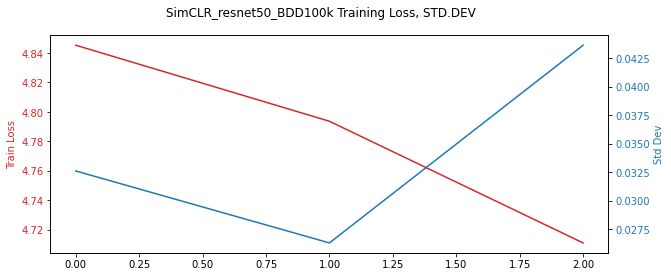

In [13]:
# visualize losses, std.devs
fig, ax1 = plt.subplots(figsize=(10,4))
ax1.set_ylabel('Train Loss', color='tab:red')
ax1.plot(np.arange(N_EPOCHS), train_losses, color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()  
ax2.set_ylabel('Std Dev', color='tab:blue')
ax2.plot(np.arange(N_EPOCHS), std_devs, color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

plt.suptitle(f'{MODEL_NAME} Training Loss, STD.DEV')
plt.show()

## Evaluation using K-Nearest Neighbours
- As there are no labels, we'll evaluate the models using **k Nearest Neighbours**, one of the popular methods to evaluate Self-supervised models. We'll define a test dataset on same directory, but without any of the augmentations / transforms. 

In [14]:
# We'll define a test transform too, without any of the augmentations
test_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((input_size, input_size)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean= [0.485, 0.456, 0.406],  # imagenet mean
            std= [0.229, 0.224, 0.225],   # imagenet std.dev
        ),
    ]
)

test_dataset = CLRDataset(rootDir=dataDir, tf=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=False, num_workers=2)

In [15]:
# Load from pretrained model
model.load_state_dict(torch.load(f"/kaggle/input/simclr_r50/pytorch/simclr-r50-bdd100k-100ep/1/SimCLR_resnet50_BDD100k_100ep.pt", map_location=device))

<All keys matched successfully>

### Generate Embeddings for the entire dataset

In [16]:
from sklearn.preprocessing import normalize

def generate_embeddings(model, dataloader):
    """Generates representations for all images in the dataloader with
    the given model
    """
    embeddings = []
    filenames = []
    with torch.no_grad():
        for img,fnames in tqdm(dataloader):
            img = img.to(device)
            emb = model.avgpool(model.backbone_forward(img)).flatten(start_dim=1)
            embeddings.append(emb.detach().cpu().numpy())
            filenames.extend(fnames)

    embeddings = np.concatenate(embeddings, axis=0)
    embeddings = normalize(embeddings)
    return embeddings, filenames


model.eval()
embeddings, filenames = generate_embeddings(model, test_dataloader)
print(f"Embeddings shape = {embeddings.shape}")

100%|██████████| 54/54 [00:16<00:00,  3.27it/s]

Embeddings shape = (3430, 2048)


## Visualize Nearest Neighbours

In [17]:
from sklearn.neighbors import NearestNeighbors

def get_image_as_np_array(filename: str):
    img = Image.open(filename)
    return np.asarray(img)

def plot_knn_examples(embeddings, filenames, n_neighbors=3, num_examples=6):
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(embeddings)
    distances, indices = nbrs.kneighbors(embeddings)

    samples_idx = np.random.choice(len(indices), size=num_examples, replace=False)
    for idx in samples_idx:
        fig = plt.figure(figsize=(num_examples * 4, 12))
        
        for plot_x_offset, neighbor_idx in enumerate(indices[idx]):
            ax = fig.add_subplot(1, len(indices[idx]), plot_x_offset + 1)
            plt.imshow(get_image_as_np_array(filenames[neighbor_idx]))
            ax.set_title(f"d={distances[idx][plot_x_offset]:.3f}")
            plt.axis("off")

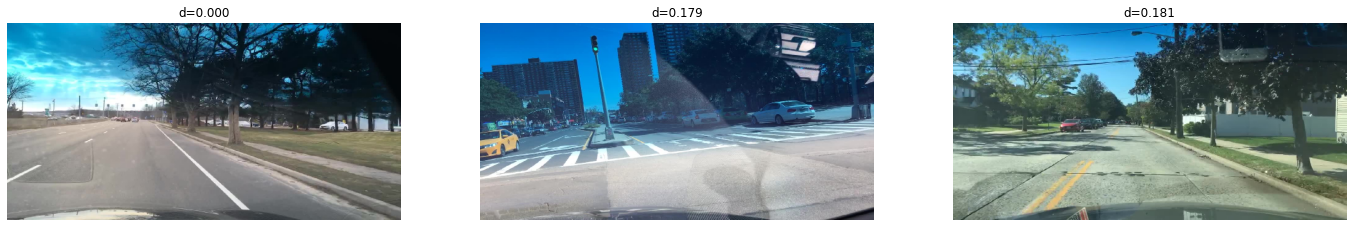

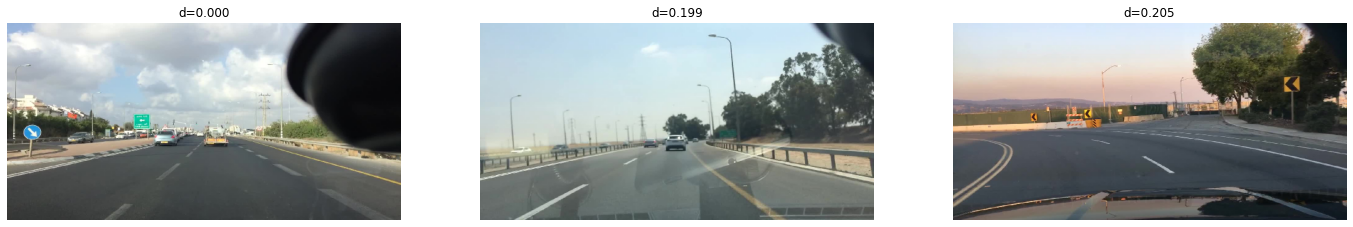

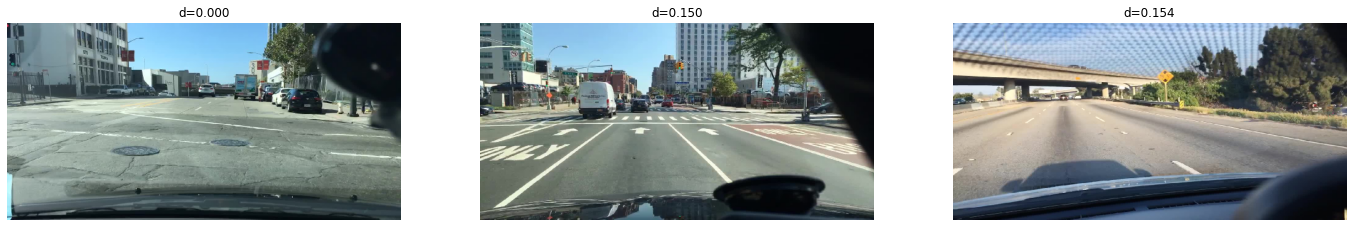

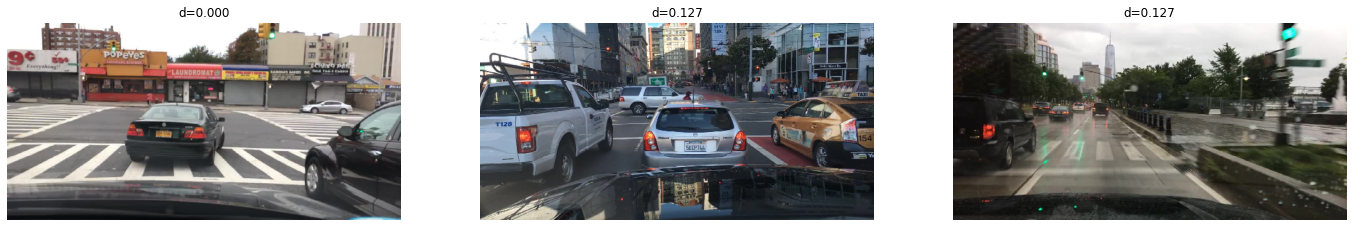

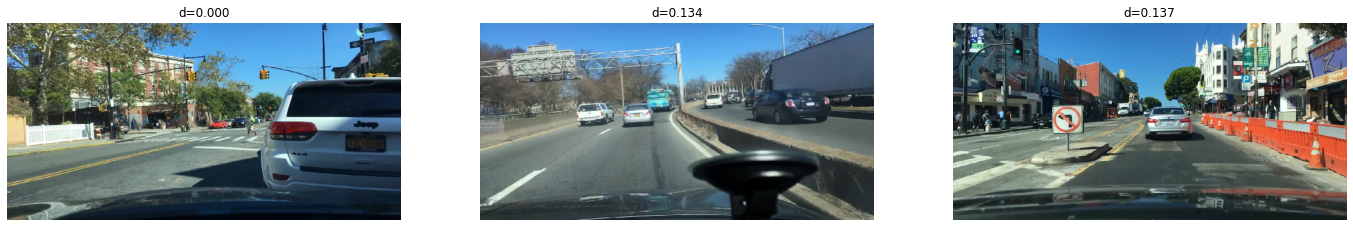

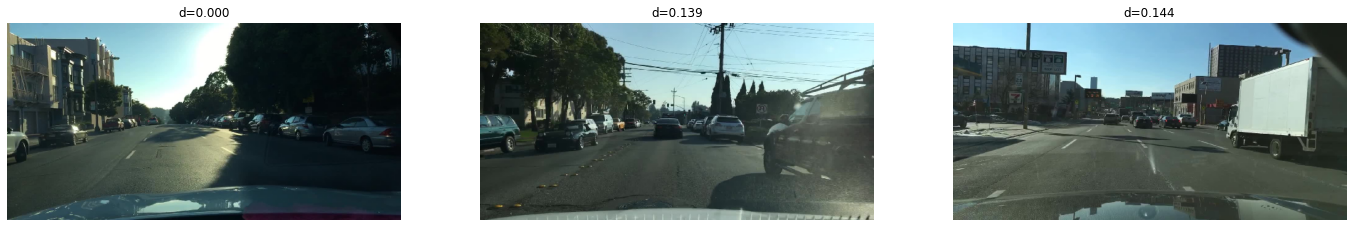

In [18]:
plot_knn_examples(embeddings, filenames)

## t-SNE plot
- Another common way to visualize the features learned by model is [t-SNE](https://lvdmaaten.github.io/publications/papers/JMLR_2008.pdf). 
- t-SNE helps project samples of higher dimensional space, to 2D space, which can be easily plotted for more intuition
- We'll first use PCA(Principal Component analysis) to reduce the embeddings space and then tSNE to visualize it

In [19]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE

# # create objects for plotting
# n_components = 64
# scaler = StandardScaler()
# pca = PCA(n_components=n_components)
# tsne = TSNE()

# # Normalize embeddings -> PCA (reduce feature dimensions)
# embeddings_pca = pca.fit_transform(scaler.fit_transform(embeddings))
# print(embeddings_pca.shape)

# tsne_results = tsne.fit_transform(scaler.fit_transform(embeddings_pca))

# import plotly.graph_objs as go
# import plotly.offline as py


# traceTSNE = go.Scatter(x = tsne_results[:,0], y = tsne_results[:,1],
#                     mode = 'markers', showlegend = False,
#     marker = dict(
#         size = 8,
#         colorscale ='Jet',
#         showscale = False,
#         line = dict(
#             width = 2,
#             color = 'rgb(255, 255, 255)'
#         ),
#         opacity = 0.8
#     )
# )
# data = [traceTSNE]

# layout = dict(title = 'TSNE (T-Distributed Stochastic Neighbour Embedding)',
#               hovermode= 'closest',
#               yaxis = dict(zeroline = False),
#               xaxis = dict(zeroline = False),
#               showlegend= False,

#              )

# fig = dict(data=data, layout=layout)
# py.iplot(fig, filename='styled-scatter')

In [20]:
# dataDistribution = {
#     'Ambulance' : 132,
#     'Bicycle' : 1618,
#     'Bus' : 2133,
#     'Car' : 6781,
#     'Motorcycle' : 2986,
#     'Taxi' : 748,
#     'Truck' : 2033,
#     'Van' : 1111,
# }